In [1]:
%pylab inline
%load_ext autotime
%load_ext autoreload
%autoreload 2
import scanpy as sc

from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct


Populating the interactive namespace from numpy and matplotlib
time: 18.8 s (started: 2021-02-28 21:47:39 -05:00)


In [2]:
pbmc33k = sc.read_h5ad("../data/pbmc33k.h5ad")
pbmc3k = sc.read_h5ad("../data/pbmc3k.h5ad")

time: 1.55 s (started: 2021-02-28 21:47:58 -05:00)


# PBMC3k

Running Step1


100%|██████████| 2000/2000 [00:53<00:00, 37.66it/s]


0
Step1 done. Took 54.0 seconds.
Running Step2
Step2 done. Took 5.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.


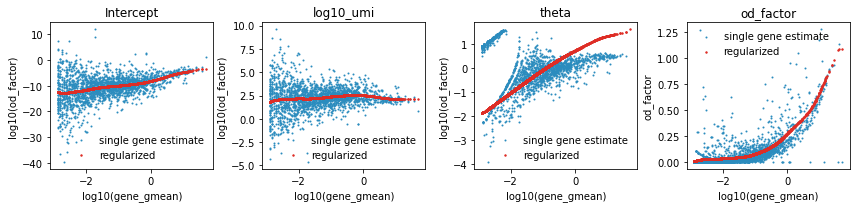

time: 1min 4s (started: 2021-02-28 21:48:00 -05:00)


In [3]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_3k)


In [4]:
np.arange(0.1, 1, step=0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

time: 39.6 ms (started: 2021-02-28 21:49:05 -05:00)


<AxesSubplot:xlabel='Residual variance'>

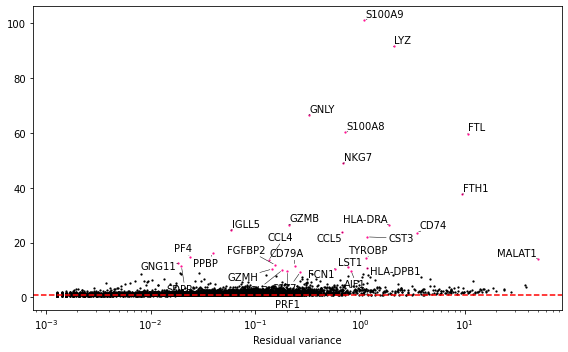

time: 17.7 s (started: 2021-02-28 21:49:05 -05:00)


In [5]:
plot_residual_var(vst_out_3k)

## Compare model parameters to R SCTransform

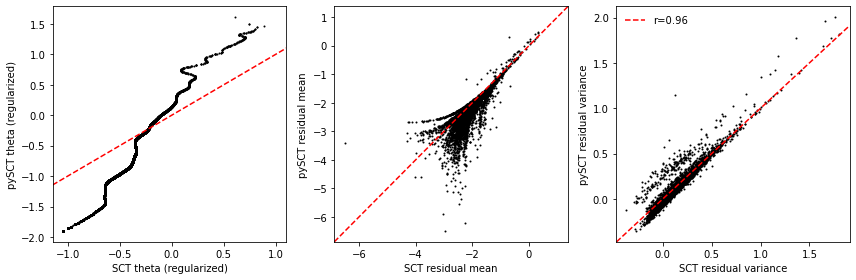

time: 614 ms (started: 2021-02-28 21:49:22 -05:00)


In [6]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )

# PBMC33k

Running Step1


100%|██████████| 2000/2000 [01:17<00:00, 25.97it/s]


0
Step1 done. Took 79.0 seconds.
Running Step2
Step2 done. Took 8.0 seconds.
Running Step3
Step3 done. Took 20.0 seconds.


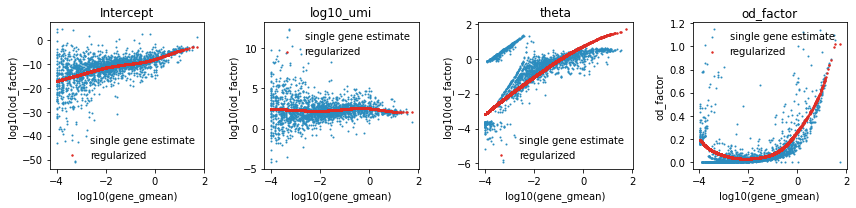

time: 2min 3s (started: 2021-02-28 21:49:23 -05:00)


In [7]:
# Input is gene x cell
vst_out_33k = vst(
    pbmc33k.X.T,
    gene_names=pbmc33k.var_names.tolist(),
    cell_names=pbmc33k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_33k)


<AxesSubplot:xlabel='Residual variance'>

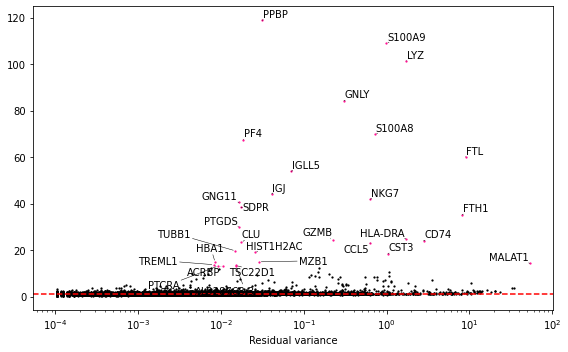

time: 5.08 s (started: 2021-02-28 21:51:27 -05:00)


In [8]:
plot_residual_var(vst_out_33k)

## Compare model parameters to R SCTransform

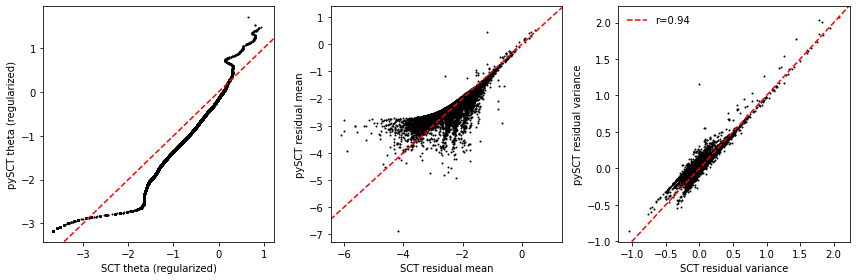

time: 745 ms (started: 2021-02-28 21:51:32 -05:00)


In [9]:
compare_with_sct(vst_out_33k, 
                 sct_modelparsfit_file="~/data/pbmc33k/pbmc33k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc33k/pbmc33k_thetaml_gene_attr.csv"
                )

# Try another estimator - theta_ml with LBFGS

Running Step1


100%|██████████| 2000/2000 [00:57<00:00, 35.09it/s]


0
Step1 done. Took 58.0 seconds.
Running Step2
Step2 done. Took 5.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.


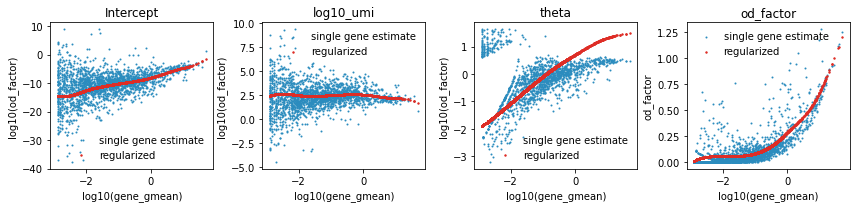

time: 1min 7s (started: 2021-02-28 21:51:32 -05:00)


In [10]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="theta_lbfgs",
)
_ = plot_fit(vst_out_3k)


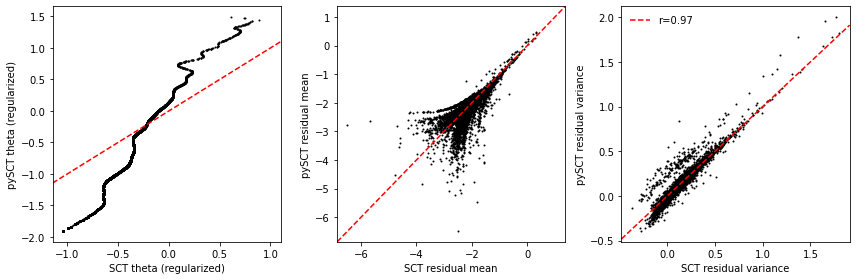

time: 522 ms (started: 2021-02-28 21:52:40 -05:00)


In [11]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )

<AxesSubplot:xlabel='Residual variance'>

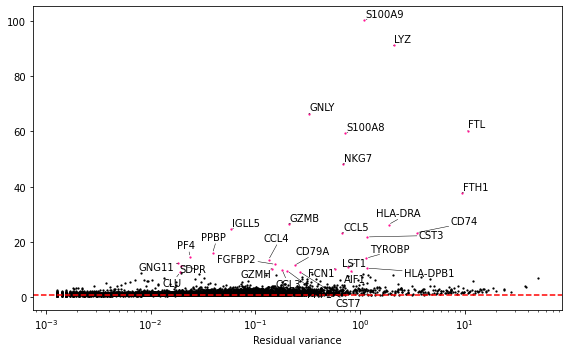

time: 22.4 s (started: 2021-02-28 21:52:40 -05:00)


In [12]:
plot_residual_var(vst_out_3k)

# Try another estimator - theta_ml with LBFGS applied to 1/theta parameter

In [13]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="alpha_lbfgs",
)


Running Step1


100%|██████████| 2000/2000 [00:48<00:00, 40.95it/s]


0
Step1 done. Took 50.0 seconds.
Running Step2
Step2 done. Took 5.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.
time: 57.1 s (started: 2021-02-28 21:53:03 -05:00)


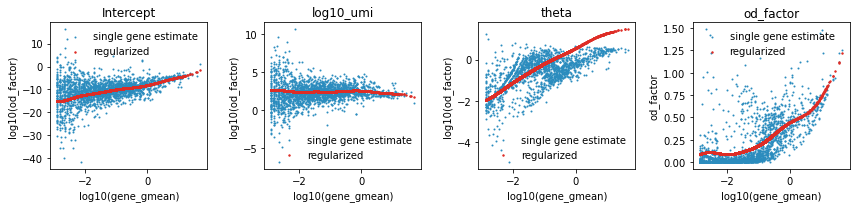

time: 2.05 s (started: 2021-02-28 21:54:00 -05:00)


In [14]:
_ = plot_fit(vst_out_3k)


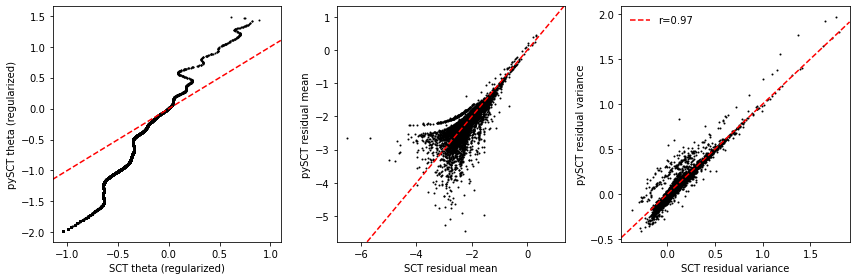

time: 526 ms (started: 2021-02-28 21:54:02 -05:00)


In [15]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )


<AxesSubplot:xlabel='Residual variance'>

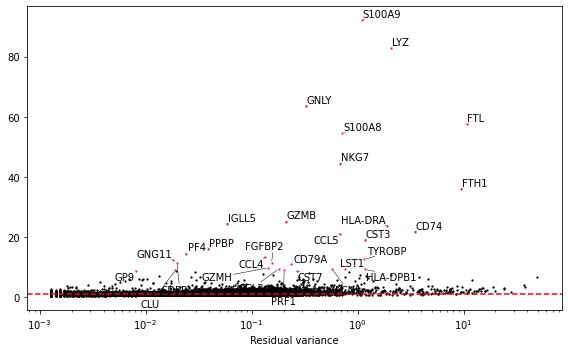

time: 20.8 s (started: 2021-02-28 21:54:02 -05:00)


In [16]:
plot_residual_var(vst_out_3k)

# Using JIT compilation

In [17]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="jax_jit",
)


Running Step1


100%|██████████| 2000/2000 [00:56<00:00, 35.58it/s]


0
Step1 done. Took 57.0 seconds.
Running Step2
Step2 done. Took 6.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.
time: 1min 5s (started: 2021-02-28 21:54:23 -05:00)


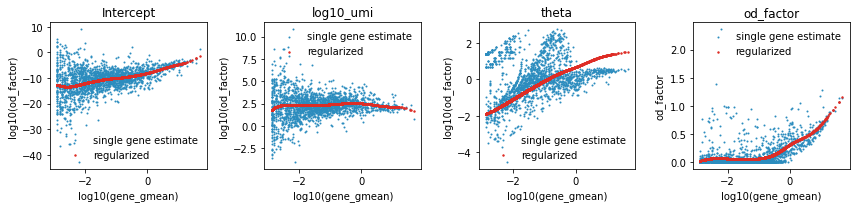

time: 2.37 s (started: 2021-02-28 21:55:28 -05:00)


In [18]:
_ = plot_fit(vst_out_3k)


<AxesSubplot:xlabel='Residual variance'>

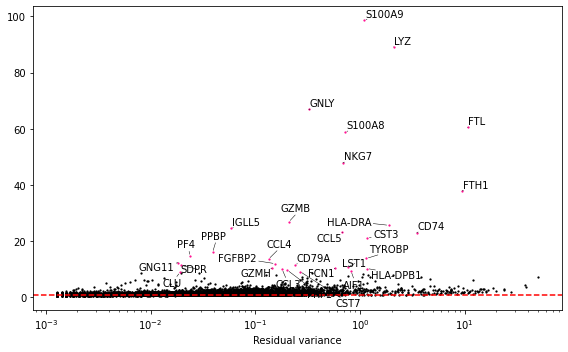

time: 21 s (started: 2021-02-28 21:55:31 -05:00)


In [19]:
plot_residual_var(vst_out_3k)